# research

> This notebook contains code for exploring existing research

In [50]:
#| default_exp research

In [51]:
#| hide
from nbdev.showdoc import *

Run installations quickly. Kernel may need to be restarted after this step

In [ ]:
!pip install -e ../

In [ ]:
pip install -r ../requirements.txt

# Survey of Existing Research
This notebook contains a survey of existing research of methods to do object detection and classification.

## Building a subset of the data

In [12]:
from dog_breed_id.data_preprocessing import read_csv_with_array_columns

In [7]:
#| export
import cv2
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt
from miniai.datasets import show_images
import shutil

In [8]:
df = read_csv_with_array_columns('../data/dogs.csv', ['bboxes'])
subset = df.sample(frac=0.1)

def copy_files(path):
    target_path = str(path).replace('data', 'datasubset')
    folder = Path(target_path).parent
    folder.mkdir(exist_ok=True, parents=True)
    shutil.copy(path, target_path)
    return

In [9]:
if not Path('../datasubset').exists():
    subset['image'].apply(copy_files)
    subset.to_csv('../datasubset/dogs.csv')
else:
    subset = read_csv_with_array_columns('../datasubset/dogs.csv', ['bboxes'])

In [13]:
subset = read_csv_with_array_columns('../data/dogs.csv', ['bboxes'])

## Mask RCNN
Mask RCNN is from the RCNN family of object detectors. Add more here

In [53]:
#| export
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F

In [64]:
#| export
def get_classes_from_frame(df, column=None):
    """gets the ['background'] + the rest of classes from a dataframe `df` with classes in column specified by `column`"""
    if column is None: column = 'category'
    classes = ['background'] + subset['category'].unique().tolist()
    return classes

In [65]:
#| export
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms import functional as F
from sklearn.preprocessing import LabelEncoder

class DogsSubsetDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.classes = get_classes_from_frame(df)
        self.id2label = {i:c for i, c in enumerate(self.classes)}
        self.label2id = {c:i for i, c in enumerate(self.classes)}

    def _label2id(self, labels):
        return [self.label2id[l] for l in labels]

    def _id2labels(self, ids):
        return [self.id2label[i] for i in ids]
        
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        img = F.convert_image_dtype(read_image(item['image']), torch.float)
        boxes = torch.as_tensor(item['bboxes'], dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        num_objs = boxes.shape[0]
        labels  = torch.ones((num_objs,), dtype=torch.int64) * self._label2id([item['category']])[0]
        image_id = idx
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        return img, target

    def __len__(self):
        return self.df.shape[0]

def collate_fn(data):
    images = [item[0] for item in data]
    images = torch.stack(images, dim=0)
    targets = [item[1] for item in data]
    return images, targets

In [69]:
#| export
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
def get_fasterrcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [70]:
#| export
from tqdm.auto import tqdm
from dog_breed_id import engine
from dog_breed_id.engine import train_one_epoch, evaluate

def train_faster_rcnn(model, df):
        # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    #device = 'cpu'
    print('Using device ', device)
    # our dataset has two classes only - background and person
    num_classes = len(get_classes_from_frame(df))
    # use our dataset and defined transformations
    dataset = DogsSubsetDataset(df)
    dataset_test = DogsSubsetDataset(df)

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=64, shuffle=True,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=16, shuffle=False,
        collate_fn=collate_fn)

    # get the model using our helper function
    #model = get_fasterrcnn_model(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    #optimizer = torch.optim.SGD(params, lr=0.01)
    # and a learning rate scheduler

    optimizer = torch.optim.SGD(
        params,
        lr=0.005,
        momentum=0.9,
        weight_decay=0.0005
    )
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=20,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 100

    for epoch in tqdm(range(num_epochs)):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), 'model-fasterrcnn.pt')
    return model

In [71]:
num_classes = len(get_classes_from_frame(subset))
model = get_fasterrcnn_model(num_classes)
model = train_faster_rcnn(model, subset)

Using device  cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: [0]  [  0/142]  eta: 0:04:18  lr: 0.000040  loss: 5.3817 (5.3817)  loss_classifier: 5.2363 (5.2363)  loss_box_reg: 0.1331 (0.1331)  loss_objectness: 0.0075 (0.0075)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 1.8215  data: 0.5782  max mem: 68322
Epoch: [0]  [ 10/142]  eta: 0:03:49  lr: 0.000395  loss: 4.9292 (4.4880)  loss_classifier: 4.7738 (4.3341)  loss_box_reg: 0.1447 (0.1428)  loss_objectness: 0.0061 (0.0064)  loss_rpn_box_reg: 0.0047 (0.0046)  time: 1.7415  data: 0.5174  max mem: 68322
Epoch: [0]  [ 20/142]  eta: 0:03:24  lr: 0.000749  loss: 1.3935 (2.6586)  loss_classifier: 1.2399 (2.5026)  loss_box_reg: 0.1453 (0.1463)  loss_objectness: 0.0047 (0.0050)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 1.6650  data: 0.4662  max mem: 68322
Epoch: [0]  [ 30/142]  eta: 0:03:07  lr: 0.001103  loss: 0.5841 (1.9800)  loss_classifier: 0.4235 (1.8260)  loss_box_reg: 0.1455 (0.1447)  loss_objectness: 0.0033 (0.0045)  loss_rpn_box_reg: 0.0047 (0.0048)  time: 1.6415  data: 0.4515  max mem: 68

Lets run a quick test of the newly trained model

In [72]:
torch.save(model.state_dict(), 'model-fasterrcnn.cuda.pt')

In [73]:
model = model.to('cpu')
torch.save(model.state_dict(), 'model-fasterrcnn.pt')
model.load_state_dict(torch.load('model-fasterrcnn.pt'))
model = model.to('cuda')
ds = DogsSubsetDataset(subset)

In [74]:
model = model.eval()
model = model.to('cuda')
with torch.no_grad():
    preds = model(ds[0][0].unsqueeze(0).to('cuda'))
preds

[{'boxes': tensor([[ 43.9568,  10.0150, 229.2309, 235.1043],
          [ 45.4039,   4.5543, 204.9929, 230.3899],
          [ 52.9517,  15.8439, 212.3408, 219.5295],
          [ 53.7447,   6.8575, 211.0337, 225.8103],
          [ 45.4274,  12.8528, 232.2770, 209.3887],
          [ 49.2782,   5.6617, 222.5279, 256.0000],
          [ 35.3998,  12.6157, 229.7697, 242.0259],
          [ 51.6166,  14.0526, 224.8081, 231.7576],
          [ 36.6662,  17.5756, 225.1926, 220.0824]], device='cuda:0'),
  'labels': tensor([ 24,  96,   1,   6,  82,  95,  70, 108,  31], device='cuda:0'),
  'scores': tensor([0.3423, 0.1407, 0.1367, 0.1209, 0.0937, 0.0811, 0.0572, 0.0552, 0.0513],
         device='cuda:0')}]

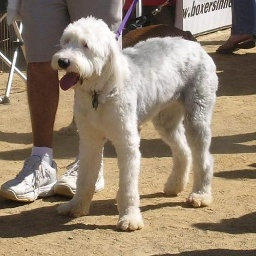

In [75]:
img = F.to_pil_image(ds[0][0])
img

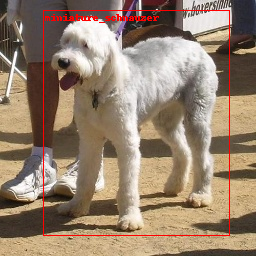

In [88]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
boxes = preds[0]['boxes']
labels = preds[0]['labels']
inp = torch.clamp((255 * ds[0][0]), 0, 255).to(torch.uint8)
output_image = draw_bounding_boxes(inp, boxes[:1].long(), ds._id2labels(labels[:1].cpu().detach().numpy()), colors="red")
output_image = F.to_pil_image(output_image)
output_image

In [89]:
#| hide
import nbdev; nbdev.nbdev_export()